In [41]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score

from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.datasets import make_regression
import xgboost as xgb
import lightgbm as lgb
import warnings
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb


warnings.filterwarnings("ignore")


def MicroStackRegressor():
        #增加特征多样性与样本多样性
    clf2 = RFR(n_estimators= 100,max_features="sqrt",max_samples=0.9, random_state=1412,n_jobs=8)
    #特征多样性，稍微上调特征数量
    clf3 = GBR(n_estimators= 100,max_features=16,random_state=1412) 

    #增加算法多样性，新增决策树与KNN
    clf4 = DTR(max_depth=8,random_state=1412)
    clf5 = KNNR(n_neighbors=10,n_jobs=8)
    clf6 = GaussianNB()

    #新增随机多样性，相同的算法更换随机数种子
    clf7 = RFR(n_estimators= 100,max_features="sqrt",max_samples=0.9, random_state=4869,n_jobs=8, min_impurity_decrease=0.0025)
    clf8 = GBR(n_estimators= 100,max_features=16,random_state=4869)

    final_estimator = RFR(n_estimators= 100,max_features="sqrt",max_samples=0.9, random_state=3217,n_jobs=8, min_impurity_decrease=0.0025)

    estimators = [("RandomForest", clf2)
                  , ("GBDT",clf3), ("Decision Tree", clf4)
        # , ("KNN",clf5) 
                  , ("RandomForest2", clf7), ("GBDT2", clf8)]

    return StackingRegressor(estimators, final_estimator)


    
    


def matrix(truth, prediction):
    mse_stack = mean_squared_error(truth, prediction)
    mae_stack = mean_absolute_error(truth, prediction)
    r2_stack = r2_score(truth, prediction)
    print('mse: %.4f' % mse_stack)
    print('mae: %.4f' % mae_stack)
    print('r2: %.4f' % r2_stack)
    print('precision: %.4f' % precision_score(truth, preprocessing.binarize(pd.DataFrame(prediction), threshold=0.5)))


考虑数据输入:
开始时间，结束时间(elapsed_time和/或point_number)，set情况(set_no)，双方局外胜率(rate)，双方当前得分(p1_score, p2_score)，开始时game获胜情况(p1_games, p2_games)，发球手(server)
输出：
game_victor

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sklearn.model_selection
from notebooks.MultiRegression import test_dataset

data = pd.read_csv("../data/data.csv")

type_var = ['match_id', 'player1', 'player2']
num_var = ['set_no', 'game_no',
            'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games',
            'server', 
           'p1_net_pt', 'p2_net_pt', 
           'p1_break_pt', 'p2_break_pt', 
            'p1_distance_run','p2_distance_run']

for var in type_var:
    le = preprocessing.LabelEncoder()
    le.fit(data[var])
    data.loc[:, var] = le.transform(data[var])

data.loc[data['point_victor'] == 2, 'point_victor'] = 0

scaler = MinMaxScaler()
data[num_var+type_var] = scaler.fit_transform(data[num_var+type_var])

x = data[num_var+type_var]
y = data["point_victor"]

x[["elo", "match_prob"]]= pd.read_csv("../data/elo_data.csv")[["sf_elo_diff_538", "match_prob_kls_EM"]]

In [45]:

print("\nStacking:")

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
predictions = pd.DataFrame(data=np.zeros(x.shape[0]), columns=["Micro Predictions"])

for train_index,test_index in kfold.split(x,y):
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    
    stack = MicroStackRegressor()
    
    # print(y_train)
    stack.fit(x_train, y_train)
    prediction = stack.predict(x_test)
    matrix(y_test, prediction)
    pred = pd.DataFrame(prediction, index=test_index, columns=["Micro Predictions"])
    
    
    predictions["Micro Predictions"][test_index] = pred["Micro Predictions"]
    # plt.plot(pred_stack[0:50], label="Stack")
    print(predictions)
predictions.to_csv("../data/micro_data.csv")


Stacking:
mse: 0.1952
mae: 0.4068
r2: 0.2183
precision: 0.7157
      Micro Predictions
0              0.000000
1              0.603169
2              0.000000
3              0.000000
4              0.000000
...                 ...
7225           0.000000
7226           0.810562
7227           0.000000
7228           0.000000
7229           0.000000

[7230 rows x 1 columns]
mse: 0.2059
mae: 0.4141
r2: 0.1758
precision: 0.6904
      Micro Predictions
0              0.000000
1              0.603169
2              0.000000
3              0.000000
4              0.788845
...                 ...
7225           0.000000
7226           0.810562
7227           0.000000
7228           0.367971
7229           0.602570

[7230 rows x 1 columns]
mse: 0.2068
mae: 0.4155
r2: 0.1729
precision: 0.6671
      Micro Predictions
0              0.000000
1              0.603169
2              0.562766
3              0.496433
4              0.788845
...                 ...
7225           0.543810
7226        

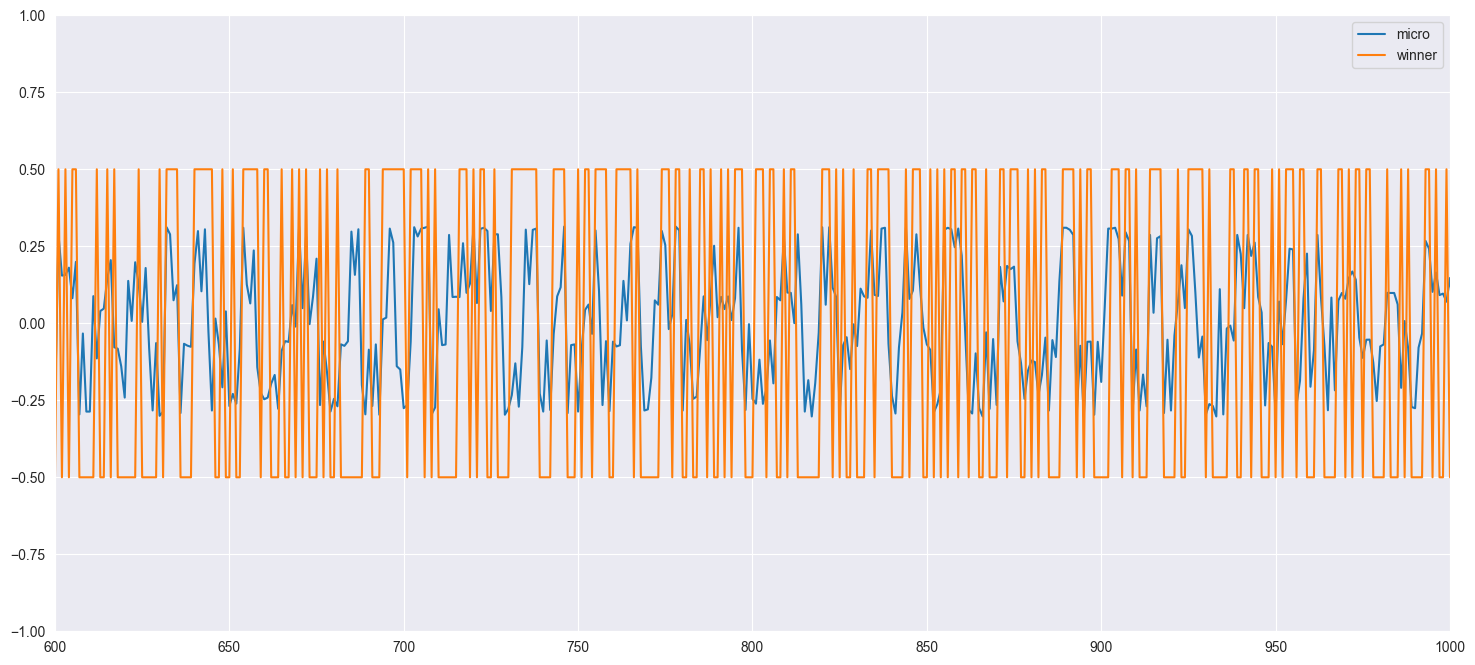

In [44]:
micro = predictions["Micro Predictions"]

pt_winner = np.asarray(y.T)

# TODO:积分， performance单独图和对比图
plt.figure(figsize=(18, 8))


plt.plot(micro-0.5, label="micro")
plt.plot(pt_winner-0.5, label="winner")
plt.xlim(left = 600, right = 1000)
plt.ylim(bottom = -1, top = 1)
plt.legend()
plt.show()
